In [ ]:
import os
import re
import nltk
import numpy as np
from tqdm import tqdm
from collections import Counter
import nltk,konlpy
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from konlpy.tag import Okt
from tkinter.filedialog import askopenfilename 
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter,resolve1
from pdfminer.pdfdevice import PDFDevice, TagExtractor
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import XMLConverter, HTMLConverter, TextConverter
from pdfminer.cmapdb import CMapDB
from pdfminer.layout import LAParams
from pdfminer.image import ImageWriter

In [8]:
'''
표제어 추출 : Lemmatization
1) stem(어간) : 단어의 의미를 담고있는 단어의 핵심 부분
2) affix(접사) : 단어에 추가적인 의미를 주는 부분
cats : cat(stem) + s(affix)

am -> be
the going -> the going
having -> have
'''

def lemma(word,part):
    n = WordNetLemmatizer()

    return n.lemmatize(word,part)

'''
어간 추출 : Stemming

am -> am
the going -> the go
having -> hav
'''
def stem(word):
    s = PorterStemmer()

    return s.stem(word)


def token(text,mode):
    if mode == 'sequence':
        token_list = sent_tokenize(text)
    elif mode == 'apostrophe':
        token_list = WordPunctTokenizer().tokenize(text)
    elif mode == 'hyphen':
        token_list = TreebankWordTokenizer().tokenize(text)
    else:
        token_list = word_tokenize(text)

    return token_list

def tag(token_list,lang='eng'):
    return nltk.tag.pos_tag(token_list,lang=lang)

In [9]:
print(stem('using'))
print(lemma('accuracy','v'))

use
accuracy


In [ ]:
class preprocessing:
    def __init__(self, input_path, output_path=None):
        self.input_path = input_path
        self.output_path = output_path

    def isExistFile(self):
        file_name = self.output_path.split('/')[-1]

        for i in os.listdir("."):
            if file_name == i:
                return True

        return False

    def pdf2txt(self):
        '''
        =============================

        return : str, text File path
        '''

        # input
        password=''
        pagenos=set()
        maxpages=0

        # output
        imagewriter = None
        rotation = 0
        codec = 'UTF-8'
        pageno = 1
        scale = 1
        caching = True
        showpageno = True
        laparams = LAParams()

        infp = open(self.input_path,"rb")
        
        if self.output_path == None:
            self.output_path = self.input_path[:-4]+'_trans.txt'
            outfp = open(self.output_path,"w",encoding='UTF8')
        else:
            outfp = open(self.output_path,"w",encoding='UTF8')
            
            
        #page total num
        parser = PDFParser(infp)
        document = PDFDocument(parser)
        page_total_num = resolve1(document.catalog['Pages'])['Count']

        #
        rsrcmgr = PDFResourceManager(caching=caching)

        # pdf -> text converter
        device = TextConverter(rsrcmgr,
                               outfp,
                               codec=codec,
                               laparams=laparams, 
                               imagewriter=imagewriter)

        # pdf -> text interpreter
        interpreter = PDFPageInterpreter(rsrcmgr,device)

        # pdf -> text start
        with tqdm(total=page_total_num) as pbar:
            for page in PDFPage.get_pages(infp,
                                          pagenos,
                                          maxpages,
                                          password=password,
                                          caching=caching,
                                          check_extractable=True):

                page.rotate = (page.rotate+rotation) % 360     
                interpreter.process_page(page)

                pbar.update(1)

        print('[INFO] pdf -> text')

        outfp.close()
        infp.close()
        
        return self.output_path
    
    def clean_text(self):
        '''
        ==========================
        '''

        f = open(self.output_path,"rb")
        line_list = []

        while True:
            line = f.readline()
            line_list.append(line)
            if not line: break

        f.close()

        # remove nextline
        word = b" ".join(line_list).split()
        sentences = b" ".join(word)


        # remove ASCII
        # define pattern 
        pattern = re.compile(b"[\x80-\xff]")
        sentences = re.sub(pattern,b"",sentences)

        sentences = sentences.split(b". ")

        f = open(self.output_path,"wb")

        for sentence in sentences:
            sentence = sentence.replace(b"- ",b'')
            sentence = sentence.replace(b"-",b'')
            #cleaned_txt.append(sentence)
            f.write(sentence + b'. ')

        f.close()
        
        print('[INFO] clean text file')
    
    def word_parsing(self,text):
        stop_words = set(stopwords.words('english')) 
        word_tokens = word_tokenize(text)
        
        result = [] 

        # 불필요한 단어들 제거
        for w in word_tokens: 
            if w not in stop_words: 
                parsing = ''.join([i for i in w if not i.isdigit()]) 
                parsing = re.sub('[-=+,#/\?:^$.@*\"※~&%}{ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', parsing)

                if parsing and parsing.isalpha() == True:
                    if not re.findall('\d+', w):
                        w = w.lower()
                        w = lemma(w,'v')
                        
                        tok = token(w,'hyphen')
                        tags = tag(tok)
                        
                        '''
                        PRP는 인칭 대명사, VBP는 동사, 
                        RB는 부사, VBG는 현재부사, 
                        IN은 전치사, NNP는 고유 명사, 
                        NNS는 복수형 명사, CC는 접속사, DT는 관사
                        '''
                        
                        if tags[0][1] not in ['DT','PRP']:
                            result.append(w)
                            
        return result
    
    def word_Frequency(self):
        f = open(self.output_path,"r")

        text = f.readline()

        # 단어의 빈도수
        shortword = re.compile(r'\W*\b\w{1,2}\b')
        text = shortword.sub('', text)

        result = self.word_parsing(text)
        cnt = Counter(result)
        
        print('[INFO] extraction word frequency')
        
        return cnt
    
    
    
def gen_example(text_path, word_list):
    '''
    text_path : list, text file paths
    word : str, generate example
    
    ==================================
    
    return : str
    '''
    
    example = {}
    
    max_len = len(word_list)
    
    for path in text_path:
        f = open(path,"r")

        text = f.readline()
        
        sent_tokenize_list = sent_tokenize(text)
        
        for sentence in sent_tokenize_list:
            for word in word_list:
                if word in sentence:
                    example[word] = sentence
                    word_list.remove(word)
                    break
                
        if len(example) == max_len:
            break
                
    return example


input_path = ['Hsueh, Li, Wu - 2018 - Stochastic Gradient Descent with Hyperbolic-Tangent Decay.pdf']

result = Counter('')
text_path = []


for path in input_path:
    pdf = preprocessing(path)
    output_path = pdf.pdf2txt()
    text_path.append(output_path)
    
    pdf.clean_text()
    cnt = pdf.word_Frequency()
    
    result += cnt

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.78it/s]


[INFO] pdf -> text
[INFO] clean text file
[INFO] extraction word frequency


In [17]:
sorted_cnt = sorted(result.items(), key=lambda t : t[1],reverse=True)
sorted_values = sorted(result.values(), reverse=True)
sorted_keys = sorted(result, key=result.get, reverse=True)

sorted_keys[:30]

['box',
 'use',
 'map',
 'feature',
 'object',
 'default',
 'ssd',
 'train',
 'network',
 'faster',
 'detection',
 'rcnn',
 'layer',
 'model',
 'image',
 'scale',
 'different',
 'result',
 'size',
 'convolutional',
 'aspect',
 'accuracy',
 'multiple',
 'input',
 'set',
 'fast',
 'show',
 'data',
 'test',
 'base']

In [18]:
def gen_example(text_path, word_list):
    '''
    text_path : list, text file paths
    word : str, generate example
    
    ==================================
    
    return : dic {'word' : 'sentence'}
    '''
    
    example = {}
    
    max_len = len(word_list)
    
    for path in text_path:
        f = open(path,"r")

        text = f.readline()
        
        sent_tokenize_list = sent_tokenize(text)
        
        for sentence in sent_tokenize_list:
            for word in word_list:
                if word in sentence:
                    example[word] = sentence
                    word_list.remove(word)
                    break
                
        if len(example) == max_len:
            break
                
    return example

In [13]:
gen_example(text_path,sorted_keys[:30])

{'accuracy': 'Often detection speed for these approaches is measured in seconds per frame (SPF), and even the fastest highaccuracy detector, Faster RCNN, operates at only 7 frames per second (FPS).',
 'aspect': '4) of default boxes of different aspect ratios at each location in several feature maps with different scales (e.g.',
 'base': '2.1 Model The SSD approach is based on a feedforward convolutional network that produces a xedsize collection of bounding boxes and scores for the presence of object class instances in those boxes, followed by a nonmaximum suppression step to produce the nal detections.',
 'box': 'Our approach, named SSD, discretizes the output space of bounding boxes into a set of default boxes over different aspect ratios and scales per feature map location.',
 'convolutional': 'The core of SSD is predicting category scores and box offsets for a xed set of default bounding boxes using small convolutional lters applied to feature maps.',
 'data': '3 presents datasetsp

In [14]:
sorted_cnt = sorted(result.items(), key=lambda t : t[1],reverse=True)
sorted_values = sorted(result.values(), reverse=True)
sorted_keys = sorted(result, key=cnt.get, reverse=True)

print(sorted_cnt[:30])

[('box', 116), ('use', 78), ('map', 75), ('feature', 72), ('object', 65), ('default', 63), ('ssd', 59), ('train', 57), ('network', 47), ('faster', 45), ('detection', 44), ('rcnn', 44), ('layer', 43), ('model', 39), ('image', 38), ('scale', 36), ('different', 32), ('result', 28), ('size', 28), ('convolutional', 26), ('aspect', 24), ('accuracy', 23), ('multiple', 23), ('input', 23), ('set', 23), ('fast', 21), ('show', 21), ('data', 21), ('test', 20), ('base', 19)]


In [19]:
import plotnine
import pandas as pd
from plotnine import *

print("plontnine version :",plotnine.__version__)

plontnine version : 0.5.1


C:\Users\woals\AppData\Local\conda\conda\envs\text\lib\site-packages\plotnine\guides\guides.py:198: UserWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
  "variable to it".format(output))


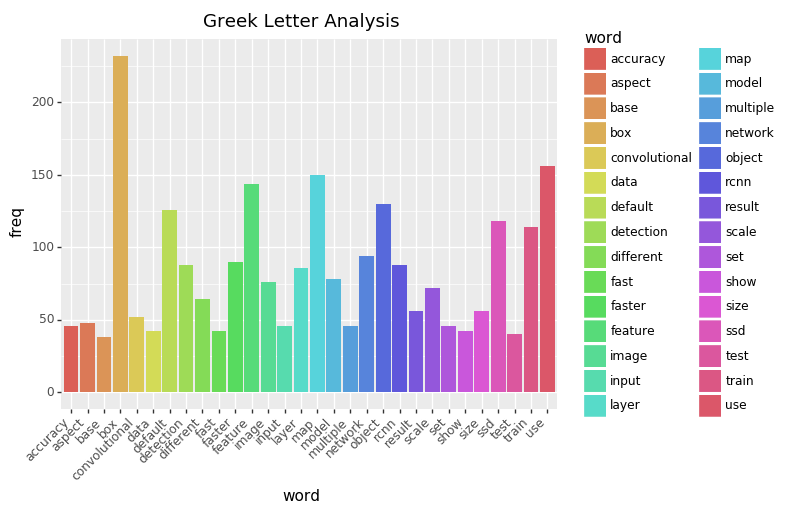

<ggplot: (121866441003)>

In [20]:
df = pd.DataFrame(sorted_cnt[:30],columns=['word','freq'])

df = pd.DataFrame({
    'word' : sorted_keys[:30] * 2,
    'freq' : sorted_values[:30] * 2
})


(ggplot(df)
 + geom_col(aes(x='word',y='freq',fill='word'))
 + scale_color_hue(l=0.45)                                  # some contrast to make the lines stick out
 + ggtitle('Greek Letter Analysis')
 + theme(axis_text_x=element_text(angle=45, hjust=1))
)